## Classical image denoising algorithms for autumn school in University of Cambridge

In this notebook there are five different image denoising algorithms which have been coded mostly with a Python library called "Operator Discretization Library (ODL)". <br>
Before iterative algorithms there is a little bit of mathematical background on what is happening in coming code section and hopefully it helps to understand the code.

In [49]:
### The packages needed for this notebook to run through.

import odl
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from select_image import select_image
# from select_geometry import geometry_and_ray_trafo
# from select_algorithm import algorithm

In [50]:
### Here one loads the image which is used in these classical algorithms. 

### Define your own path to the image.
path = '/home/asalline/Documents/summer2023/algorithms/usable_full_AGD_50_000230.tiff'

### Load the image.
image = cv.imread(path, cv.IMREAD_UNCHANGED)
image = image[90:410, 90:410]
# image = image[0:320:factor, 0:320:factor]

### Normalizing the image and taking its shape.
image = image / np.max(np.max(image))
shape = np.shape(image)

### Fan beam geometry and ray transform:

In the next code section one defines a fan beam geometry which simulates the geometry of the CT-scan. <br>
After the geometry is defined, one defines a domain for ray transform and ray transform itself.

In [64]:
### There is couple of parameters:

### What kind measurement environment one wants to choose.
### Possible options are 'full', 'sparse', 'limited'.
setup = 'full'

### Factor down amount of the detection lines, must be int.
factor_lines = 2

### Radius from the source to object.
source_radius = 2

### Radius from te object to detector.
detector_radius = 1

if setup == 'full':
    angles = odl.uniform_partition(0, 2*np.pi, 360)
    lines = odl.uniform_partition(-np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'sparse':
    angle_measurements = 50
    line_measurements = int(1024/factor_lines)
    angles = odl.uniform_partition(0, 2*np.pi, angle_measurements)
    lines = odl.uniform_partition(-1*np.pi, np.pi, line_measurements)
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'limited':
    starting_angle = 0
    final_angle = np.pi * 1/2
    angles = odl.uniform_partition(starting_angle, final_angle, 360)
    lines = odl.uniform_partition(-1*np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)


### The domain is defined here, there is couple of parameters:

### Imagine a box in 2D-plane with this parameter being the most southwest point of the box.
min_domain_corner = [-1,-1]

### Imagine a box in 2D-plane with this parameter being the most northeast point of the box.
max_domain_corner = [1,1]

### Number of samples per axis.
shape = shape

### Data type 
dtype = 'float'

domain = odl.uniform_discr(min_domain_corner, max_domain_corner, shape=shape, dtype=dtype)

### The ray transform is defined here

device = 'astra_cpu'

ray_transform = odl.tomo.RayTransform(domain, geometry, impl=device)

### Sinogram and noise

Next up is using the ray transform to obtain a sinogram from the image. <br>
After that one can/will add there noise, in this notebook Gaussian noise is used.

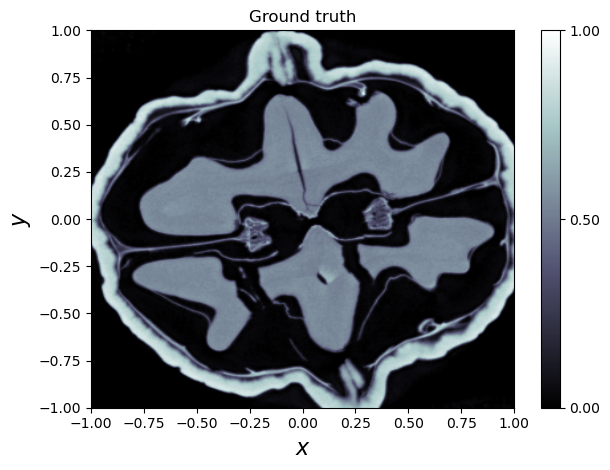

<Figure size 640x480 with 0 Axes>

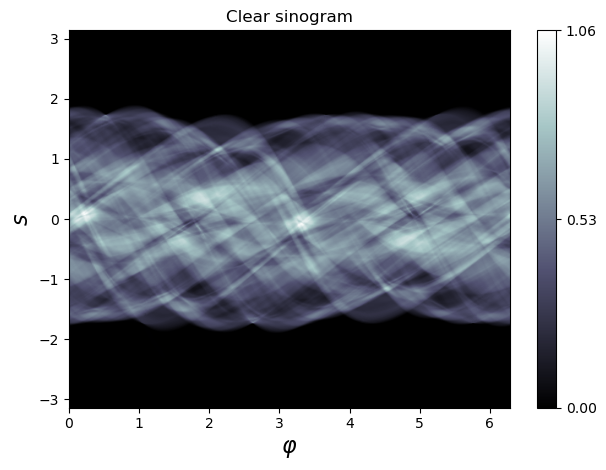

<Figure size 640x480 with 0 Axes>

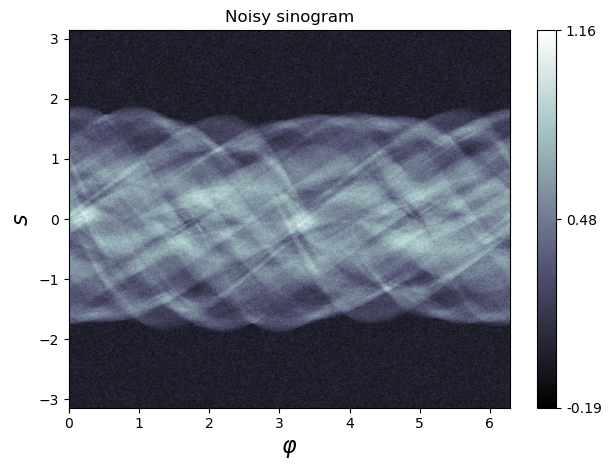

<Figure size 640x480 with 0 Axes>

In [65]:
### First convers image into ODL form
image = domain.element(image)

### Use ray transform to the image to obtain sinogram
sinogram = ray_transform(image)

### Parameters for the Gaussian noise
mean = 0.0
variance = 0.002
sigma = variance ** 0.5

### Create noisy sinogram
noisy_sinogram = sinogram + np.random.normal(mean, sigma, size=(np.shape(sinogram)[0], np.shape(sinogram)[1]))

image.show('Ground truth')
sinogram.show('Clear sinogram')
noisy_sinogram.show('Noisy sinogram')
plt.show()

## Reconstruction methods

Last sections contain different kind of reconstruction algorithms. <br>

### Filtered Back Projection (FBP):

This is the approximate inverse of ray transform. <br>
This is easy to define in the ODL as one can see below.

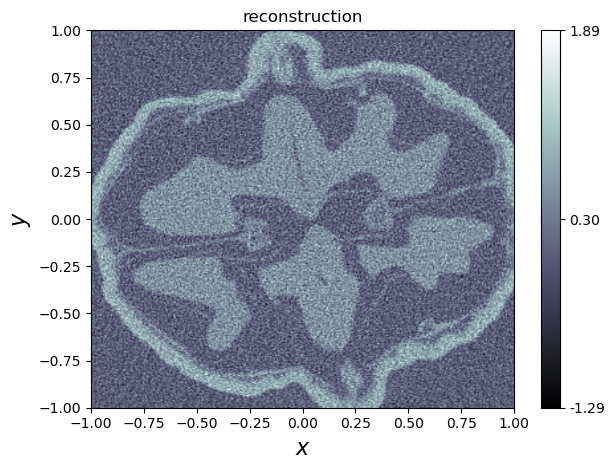

<Figure size 640x480 with 0 Axes>

In [66]:
### There is function in ODL to create FBP operator:
FBP_operator = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo=ray_transform, padding=1)

### One just applies the noisy sinogram with just defined FBP operator and gets a reconstruction out.
reconstruction = FBP_operator(noisy_sinogram)

### Because in these sections the images are plotted in ODL domain the next thing is needed:
reconstruction = domain.element(reconstruction)

### Plotting the reconstructed image
reconstruction.show('reconstruction')
plt.show()

### Tikhonov regularization

This is the first iterative algorithm. It is based on a regularization theory and it is a minimization problem formulated as <br>
$$
\argmin_f \mathcal{E}(f) = \argmin_{f} \{ ||Af - g||^2_2 + \lambda ||Bf||^2_2 \}
$$
Above minimization problem can be understood such that the final answer $f$ should give a good balance between small residual in the first norm and a small value in $L^2$-norm. <br> 
That minimization problem can be solved iteratively with gradient descent. For one to solve the iterative step, the first thing to do is take a derivative of the minimization problem with respect to $f$ and setting it equal to zero. <br>
That then yields an equation which looks like 
$$
\nabla_f \mathcal{E}(f) = (A^T A + \lambda B^T B)f - A^T g
$$
In this case we will also set that $B = I$ and that then gives 
$$
\nabla_f \mathcal{E}(f) = (A^T A + \lambda I)f - A^T g = Tf - b
$$
That equation is now used in the gradient descent such that the iterative step is given as
$$
f_{i+1} = f_i - \beta \nabla_f \mathcal{E}(f_i) = f_i - \beta (T f_i - b)
$$
On below there is then a code with this formulation.

Iteration 0/250
Iteration 50/250
Iteration 100/250
Iteration 150/250
Iteration 200/250


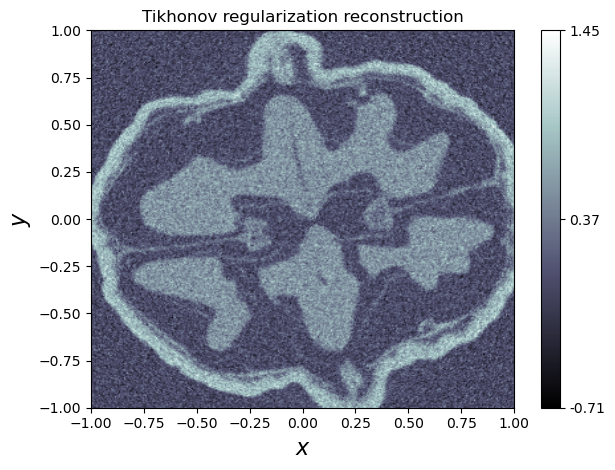

<Figure size 640x480 with 0 Axes>

In [68]:
### Renaming ray transform as "operator"
operator = ray_transform

### Defining step size "beta" which is depends on the value of the operator norm
operator_norm = 1.1 * odl.power_method_opnorm(operator)
beta = 1/(operator_norm**2)

### This is how one defines ideneity operator in ODL
id = odl.IdentityOperator(domain)

### Lambda parameter
lam = 0.0005

### Operator "T" defined just as written in equation above
T = operator.adjoint * operator + lam *  id.adjoint * id

# Tgrad = operator.adjoint * operator

### Evaluating "b" like written above
b = operator.adjoint(noisy_sinogram)

### Amount of iterative steps
iterations = 250

### Starting point f_0 is zero matrix
f_new = domain.zero()

### Here is the iterative loop
for k in range(iterations):
    if k % 50 == 0:
        print(f'Iteration {k}/{iterations}')
    
    ### Iterative step
    f_old = f_new
    f_new = f_old - beta * (T(f_old) - b)
    # f_old = f_new

tikhonov_reconstruction = domain.element(f_new)
tikhonov_reconstruction.show('Tikhonov regularization reconstruction')
plt.show()

### Total variation regularization

Here one sets the regularization term to be $\mathcal{R}(f) = || \ |\nabla f| \ ||_1$. Thus the minimization problem becomes then
$$
\argmin_f \mathcal{E}(f) = \argmin_f \{ ||Af - g||^2_2 + \lambda || \ |\nabla f| \ ||_1 \}
$$
This time gradient descent algorithm is unusable, since the regularization term is not differentiable. One overcomes this problem with so called proximal gradient method. <br>
The proximal gradient method is defined as a iteration step
$$
f_{i+1} = \text{prox}_{\mathcal{R}, \beta \lambda} \big( f_i - \beta A^* (A f_i - g) \big)
$$
where $A^* (A f_i - g)$ is just a gradient of the first norm and the proximal operator $\text{prox}_{\mathcal{R}, \beta \lambda}$ is defined as 
$$
\text{prox}_{\mathcal{R}, \beta \lambda}(h) = \argmin_y \{ \beta \lambda \mathcal{R}(y) + \frac{1}{2} || h- y ||^2_2 \}
$$
In the next code section one uses Primal-Dual Hybrid-Gradient (PDHG) algorithm to solve this iterative problem. ODL has very nice feature that calculates proximal operator of the functional (let's say "T") with command "T.proximal". PDHG algorithm relies on that feature and that is why it is suitable to solve this minimization problem. <br>
Before one continues into code, it should be stated that PDHG algorithm is solving the problem in a form of (sorry for the inconvenient notations)
$$
\min_x f(x) + g(Lx)
$$
Here PDHG converges only if $L$ is linear and the primal and dual iteration step lengths $\sigma$ and $\tau$ satisfy that $\sigma \tau ||L||_{operator}^2 < 1$ <br>
Considering imaging problem stated above, one sets $f(x)=0$ and $L(x) = (A(x), \nabla x)$. Then with these settings define $g$ as a function of two variables $g(x_1, x_2) = ||x_1 - y||^2_2 + ||x_2||_1$ which yields then the imaging problem.


/home/asalline/anaconda3/lib/python3.10/site-packages/scipy/sparse/_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


iter = 0


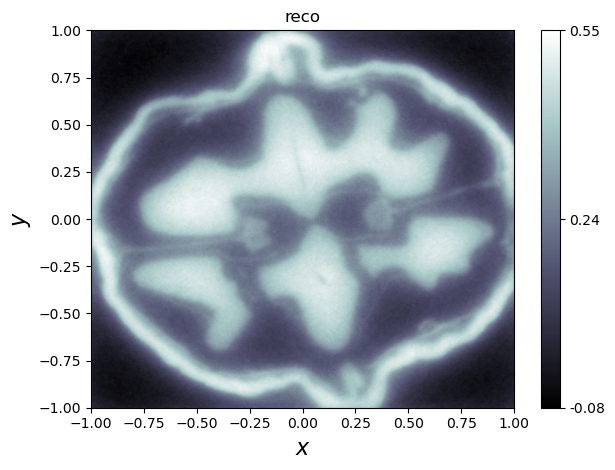

<Figure size 640x480 with 0 Axes>

In [40]:
### First one defines the gradient over the domain of the problem
gradient = odl.Gradient(domain)

### Regularization term penalty constant
lam = 1e-4

### (Column) vector of the operator (ray transform) and the gradient
L = odl.BroadcastOperator(operator, gradient)

### Data consistency term
l2_norm_squared = odl.solvers.L2NormSquared(operator.range).translated(noisy_sinogram)

### Regularization term
l1_norm = lam * odl.solvers.L1Norm(gradient.range)

### Combining the norm-terms
### The order must correspond to formulation!
g = odl.solvers.SeparableSum(l2_norm_squared, l1_norm)

### Setting f(x) = 0
f = odl.solvers.ZeroFunctional(L.domain)

### Selecting optimization parameters tau and lambda
operator_norm_pdhg = 1.1 * operator_norm
tau = 1.0 / operator_norm_pdhg
sigma = tau

### Iteration steps
niter = 5
### Setting a starting point to zero matrix
x = domain.zero()

callback = (odl.solvers.CallbackPrintIteration(step=50))

odl.solvers.pdhg(x, f, g, L, tau = tau, sigma = sigma, niter = niter, callback=callback)

# print(type(x))
# x = x / np.max(np.max(x))
x.show('reco')
plt.show()

One other option is to smoothly approximate TV-regularization term with some constant $\beta > 0$ such that it get a form
$$
\mathcal{R}(f) = || |\nabla f|_\beta ||_1 = \left\| \sqrt{\sum_i (\partial_i f)² + \beta^2} \right\|_1
$$
which is now differentiable. <br>
One can use variational calculus to compute its gradient (which is a good exercise) and can obtain after calculations that the gradient is 
$$
\nabla_f \mathcal{R}(f) = -\text{div} \left( \frac{\nabla f}{\sqrt{\sum_i (\partial_i f)² + \beta^2}} \right)
$$
Then a gradient of the data fidality term is
$$
\nabla_f [ || Af - g ||_2 ] = 2 A^* (Af - g) = T_1 (Af -g) = T_2 f - T_1 g = T-2 f - b
$$
Now one can use the basic gradient descent algorithm to obtain reconstruction. Code implementation is shown below.

Iteration 0/5


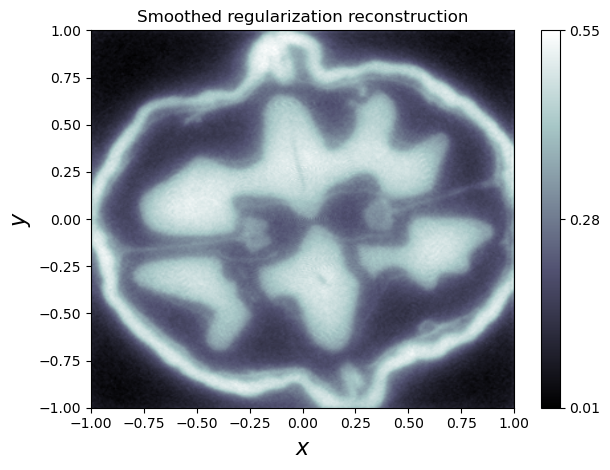

<Figure size 640x480 with 0 Axes>

In [41]:
### Defining operators given above
T_1 = 2*operator.adjoint
T_2 = T_1*operator
divergence = - odl.Divergence(gradient.range)

### Evaluating b = T_1 * g
b = T_1(noisy_sinogram)

### Initializing f to zero
f_old = domain.zero()

### Amount of iterations
iterations = 5

### Parameters
step_size = 1/(operator_norm**2)
beta = 0.00005 #0.005
lam = 0.05 #0.05

for k in range(iterations):
    if k % 50 == 0:
        print(f'Iteration {k}/{iterations}')
    
    ### Iterative step
    const = domain.one() * (np.sqrt(np.sum(np.sum(gradient(f_old)**2)) + beta))
    division = gradient(f_old) / const
    f_new = f_old - step_size * ((T_2(f_old) - b) - lam * divergence(division))
    f_old = f_new

const = domain.one() * (np.sqrt(np.sum(np.sum(gradient(f_old)**2)) + beta))
division = gradient(f_old) / const
# grad = (T_2(f_old) - b) - lam * divergence(division)
# grad = domain.element(grad)
smoothed_reconstruction = domain.element(f_new)
smoothed_reconstruction.show('Smoothed regularization reconstruction')
# grad.show('gradient')
plt.show()


### Wavelet denoising

Lastly in this notebook is the wavelet denoising. It is formulated mathematically as
$$
\min_f \mathcal{E}(x) = \min_f \{ ||A W^{-1} f - g ||_2^2 + \lambda ||f||_1 \}
$$
where now $A$ is still ones operator and $W^{-1}$ is an inverse of the wavelet transform (in this notebook a Haar transform). <br>
Here to solve minimization problem the accelerated proximal gradient (Fast Iterative Soft-Thresholding Algorithm, FISTA) is used. It solves a problem
$$
\min_x f(x) + g(x)
$$
where $f$ needs to have a proximal operator and $g$ needs to have a gradient and $\nabla g$ is $\frac{1}{\beta}$-Lipschitz continuous. Also the algorithm converges only if the step length $\gamma \in ]0, 2\beta[$.

[ 0.,  0.,  0., ...,  1.,  1.,  1.]
iter = 0


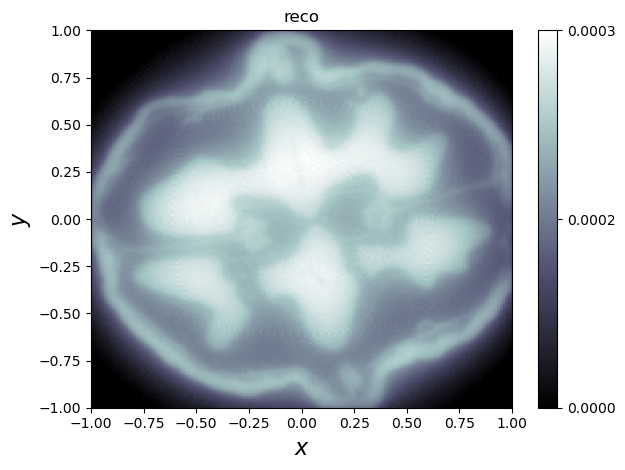

<Figure size 640x480 with 0 Axes>

In [43]:
### Creating the wavelet transform
wavelet = odl.trafos.WaveletTransform(domain, wavelet='haar', nlevels=1)

### STRAIGHT FROM ODL EXAMPLE
# The wavelets bases are normalized to constant norm regardless of scale.
# since we want to penalize "small" wavelets more than "large" ones, we need
# to weight by the scale of the wavelets.
# The "area" of the wavelets scales as 2 ^ scale, but we use a slightly smaller
# number in order to allow some high frequencies.
scales = wavelet.scales()
print(scales)
inverse_wavelet = wavelet.inverse * (1 / (np.power(1.7, scales)))

### Data discrepancy term
L2_norm_squared = odl.solvers.L2NormSquared(operator.range).translated(noisy_sinogram)

### Add the operator "A" and the inverse wavelet transform to the data discrepancy term.
### This is done from right in given order since when evaluated it starts from the right.
### L2Norm(A(W⁻1(f))).
g = L2_norm_squared * operator * inverse_wavelet

### Create regularization term
lam = 0.0005
f = lam * odl.solvers.L1Norm(wavelet.range)

### Step length that satisfies the condition.
gamma = 0.2

### Amount of iterations
iterations = 5

callback = (odl.solvers.CallbackPrintIteration(step=50))

# def callb(x):
#     """Callback that displays the inverse wavelet transform of current iter."""
#     callback(inverse_wavelet(x))

x = g.domain.zero()
odl.solvers.accelerated_proximal_gradient(x, f, g, niter=iterations, gamma=gamma, callback=callback)

inverse_wavelet(x).show('reco')
plt.show()
